In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Updates coordinates in Yang precipitation files.  Individual station trajectories are written to a separate files.

In [27]:
import pandas as pd
import datetime as dt
import os

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [4]:
def read_yang(fili):
    """
    Reads Excel file containing Yang corrected monthly precipitation
    
    Arguments
    ---------
    fili - file path
    
    Returns
    -------
    Pandas dataframe containing monthly precipitation
    """
    df = pd.read_excel(fili, sheet_name='monthly-all', header=0, skiprows=[1,2,3], 
                   na_values='-', usecols=14)
    df = df.dropna(how='all')
    return df

In [20]:
def read_position(fili):
    """
    Reader for position files contained in the NPSNOW dataset

    Arguments
    ---------
    fili - file path

    Returns
    -------
    Pandas dataframe containing drifting station positions
    """

    import calendar
    import datetime as dt
    
    df = pd.read_csv(fili, header=None, delim_whitespace=True,
                     names=['year','month','day','hour','lat','lon'])
    df['hour'][df['hour'] == 24] = 0 #There is no hour 24
    if (df['hour'] > 24).any():
        df['hour'][df['hour'] > 24] = 12

    # This is a fix to deal with non-valid dates: e.g. 30 February
    isday = [row[1]['day'] <= \
             calendar.monthrange( int(row[1]['year']),int(row[1]['month']) )[1] \
             for row in df.iterrows()]
    df = df[isday] # only return rows with valid date

    df.index = [dt.datetime(int( '19{:2d}'.format(row[1]['year']) ),
                            int(row[1]['month']),
                            int(row[1]['day']),
                            int(row[1]['hour'])) \
                for row in df.iterrows()]
    df['lat'] = df['lat'].floordiv(1000).astype(float) + \
                df['lat'].mod(1000).divide(600)
    df['lon'] = df['lon'].floordiv(1000).astype(float) + \
                df['lon'].mod(1000).divide(600)
    
    return df[['lat','lon']]


In [6]:
def llaverage(x):
    if (x['lon'].max() > 270.) and (x['lon'].min() < 90.):
        xd = x.copy()
        xd['lon'].where(xd['lon'] < 180., xd['lon']-360., inplace=True)
        result = xd.mean()
        if result['lon'] < 0.: result['lon'] = result['lon']+360.
        return result
    else:
        return x.mean()

## Get Yang precipitation data

In [8]:
ediri = r'C:\Users\apbarret\Documents\data\Arctic_precip'
efile = r'NPP-yang_copy_apb.xls'
ppt_df = read_yang(os.path.join(ediri,efile))

In [9]:
ppt_df.head()

,NP,YY,MM,ND,Lat,Lon,Tmn,Ug,DP,Dtc,snow%,Pg,windC,traceC,Pc
0,31.0,89.0,1.0,31.0,74.51,-150.67,-31.2,4.7,5.0,25.0,100.0,2.0,1.5,2.5,6.0
1,31.0,89.0,2.0,28.0,74.70,-147.57,-20.3,4.7,19.0,8.0,100.0,21.3,20.3,0.8,42.4
2,31.0,89.0,3.0,31.0,75.30,-146.08,-28.8,3.9,6.0,24.0,100.0,4.3,4.3,2.4,11.0
3,31.0,89.0,4.0,30.0,75.48,-146.26,-22.2,3.6,9.0,20.0,100.0,5.1,2.6,2.0,9.7
4,31.0,89.0,5.0,31.0,75.46,-146.25,-11.2,3.2,18.0,12.0,100.0,7.4,2.9,1.2,11.5


In [56]:
def parse_date(df):
    """
    parses date from Yang DataFrame to be used as index
    """
    date = []
    for y, m in zip(df['YY'].astype(int), df['MM'].astype(int)):
        if y > 30:
            y = y+1900
        else:
            y = y+2000
        date.append(dt.datetime(y,m,1))
    return date

def extract_station(df, np):
    newDf = df[df['NP'] == np].copy()
    newDf.index = parse_date(newDf)
    newDf.drop(['YY','MM'], axis=1, inplace=True)
    return newDf

def position_month(np):
    pos_diri = r'C:\Users\apbarret\Documents\data\SnowOnSeaIce\NPSNOW'
    pos_file = os.path.join(pos_diri,'position','position.{:02d}'.format(np))
    position = read_position(pos_file)
    mposition = position.resample('MS').agg(llaverage)
    return mposition

C:\Users\apbarret\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


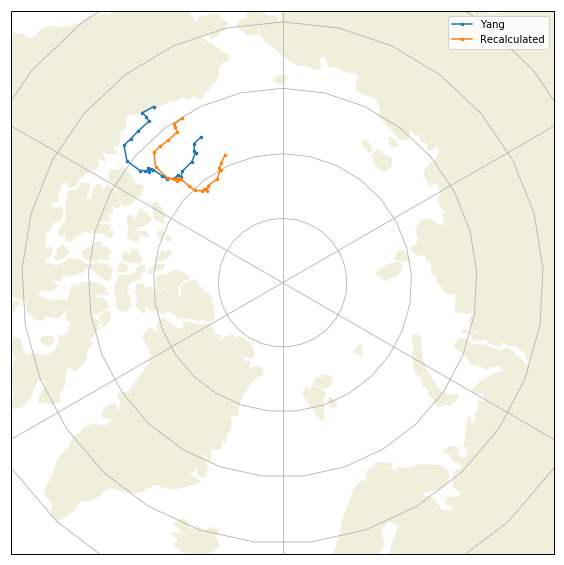

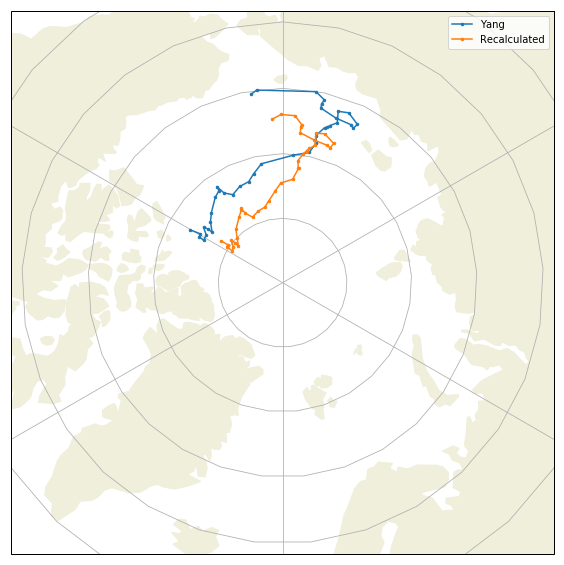

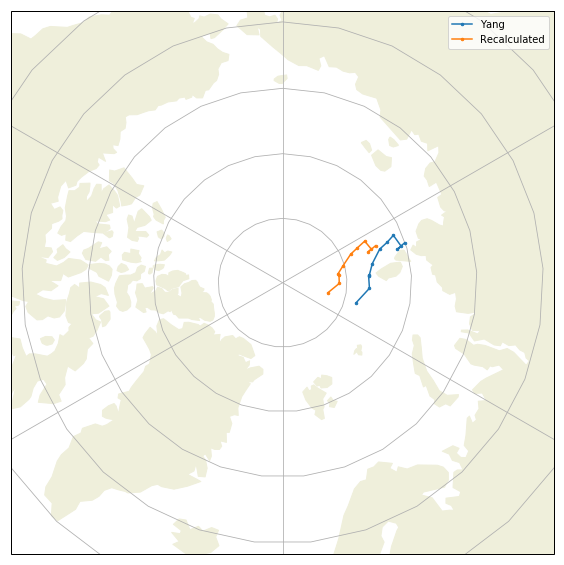

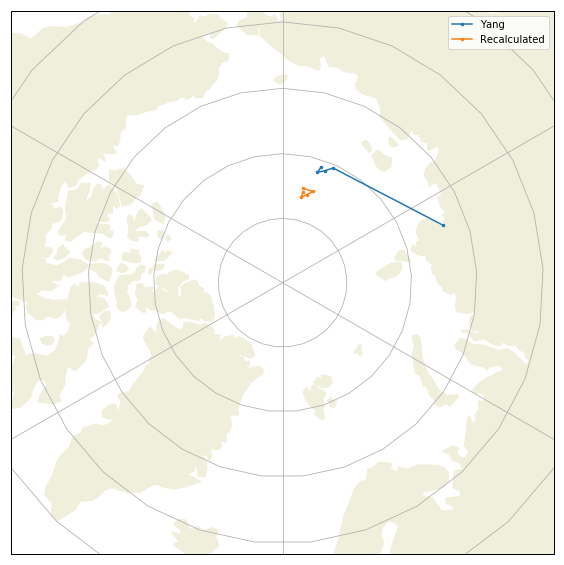

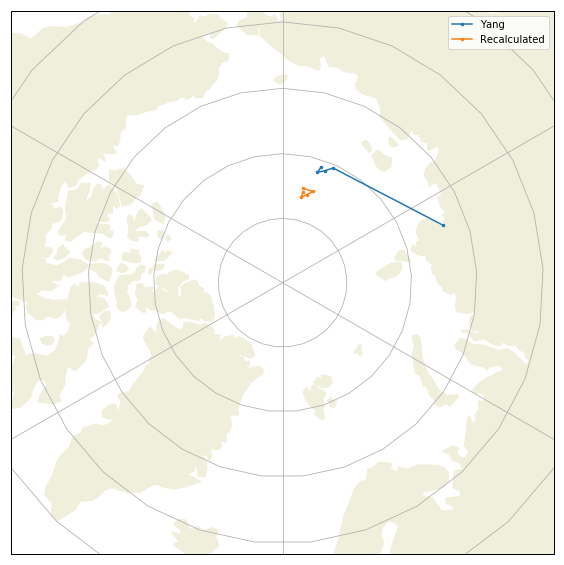

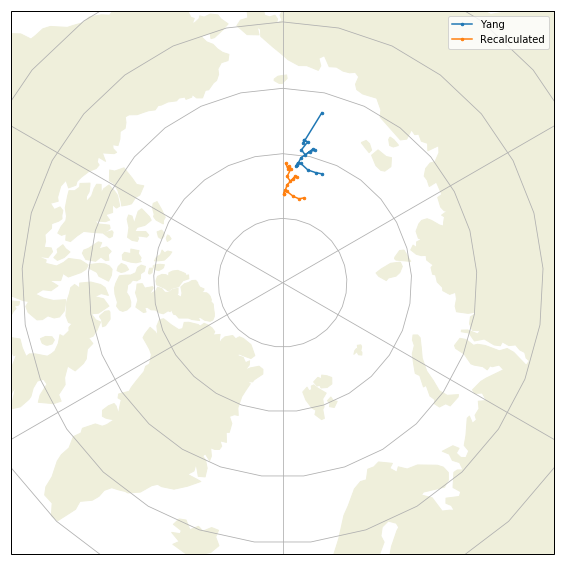

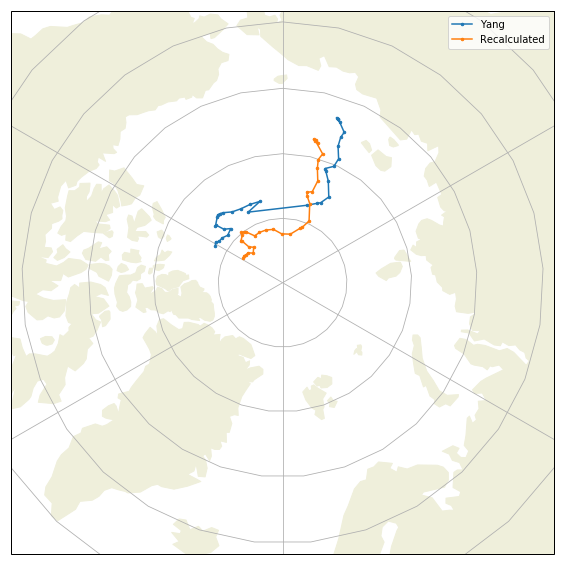

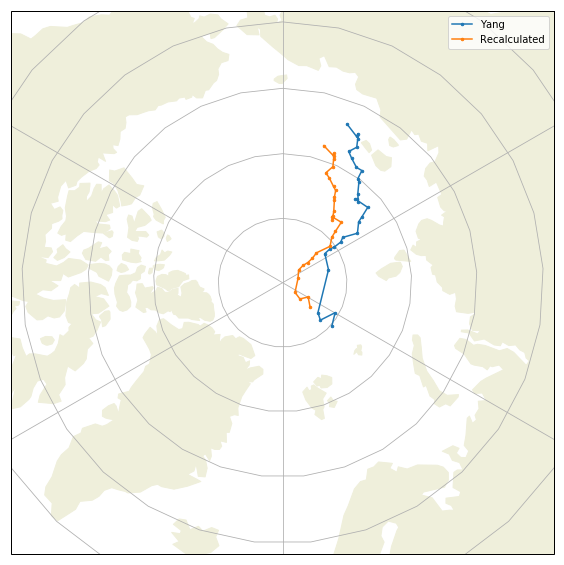

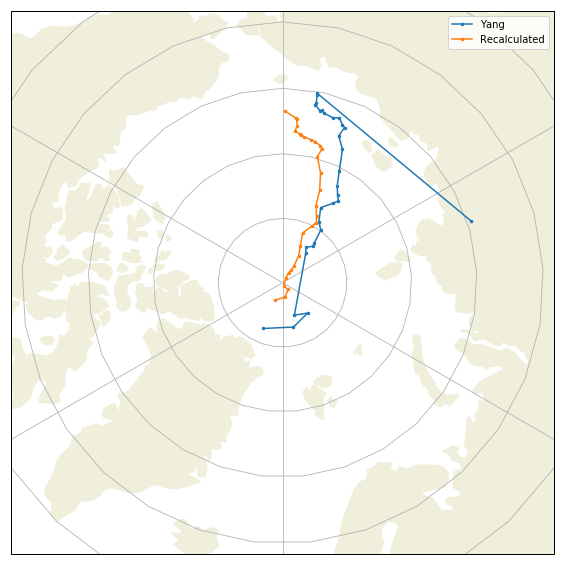

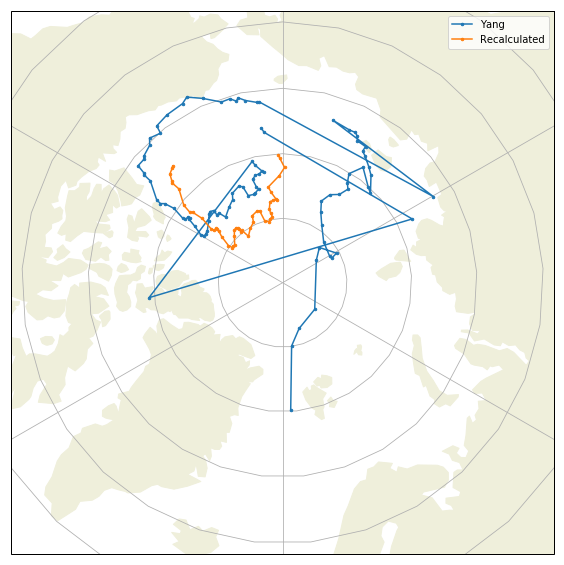

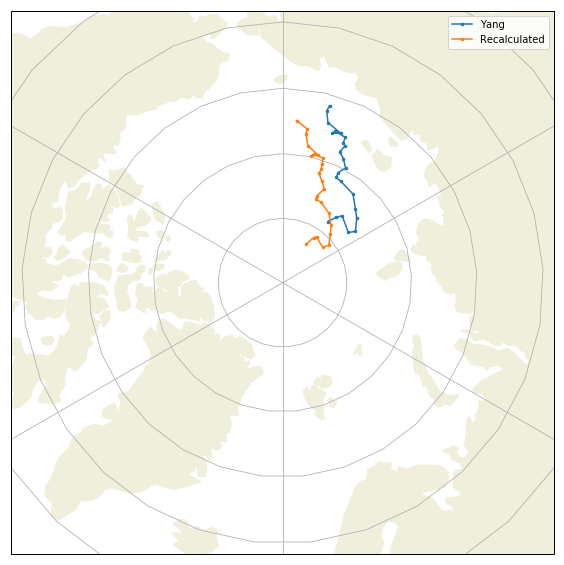

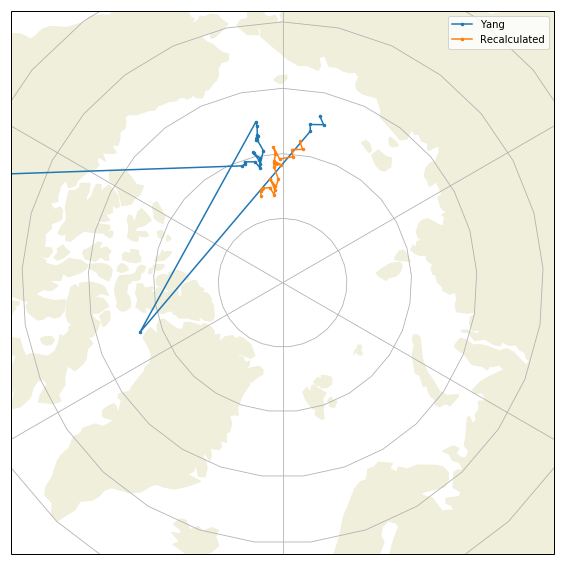

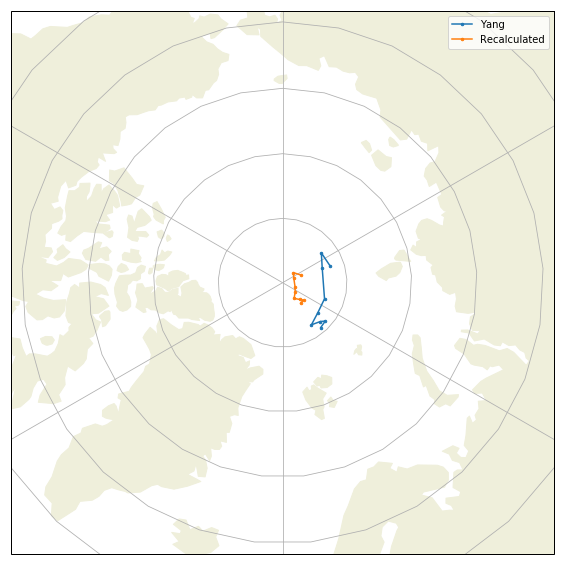

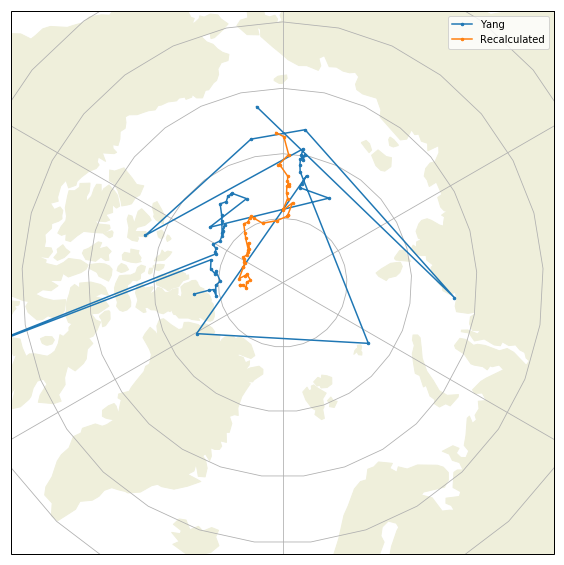

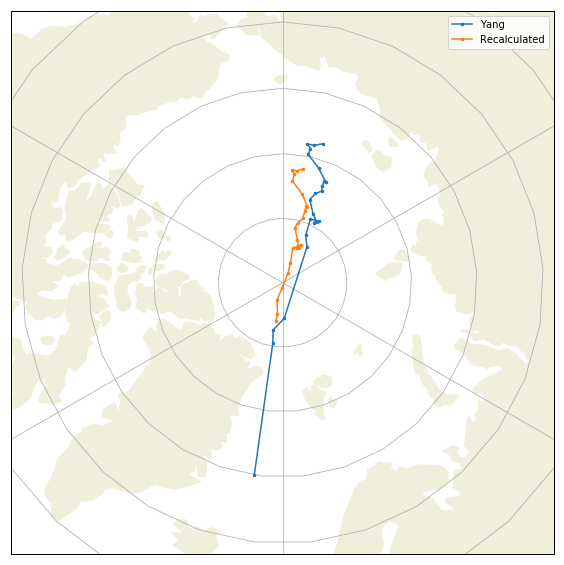

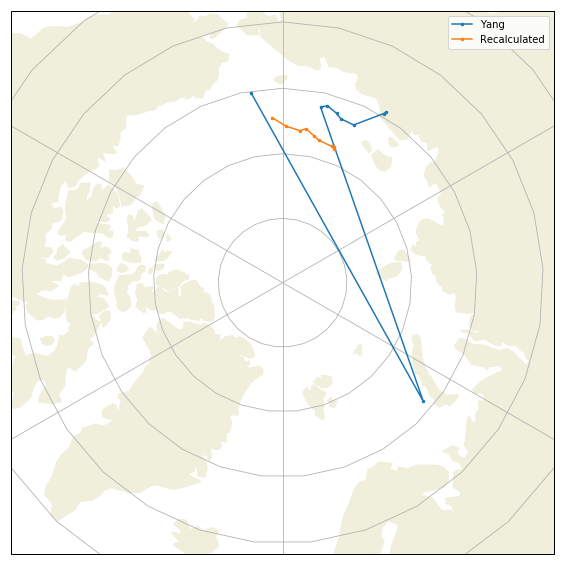

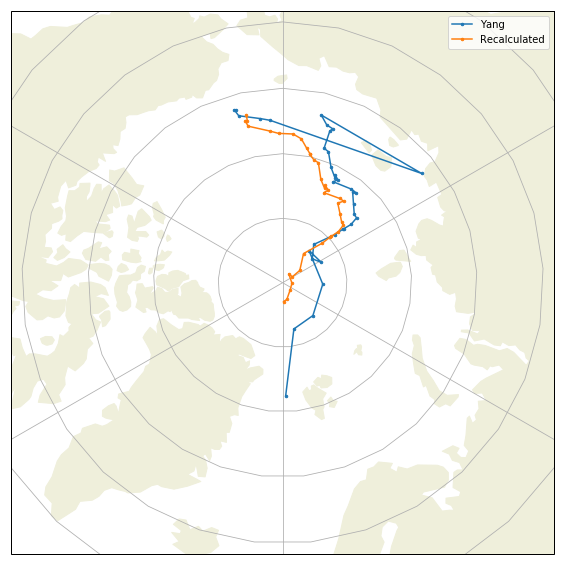

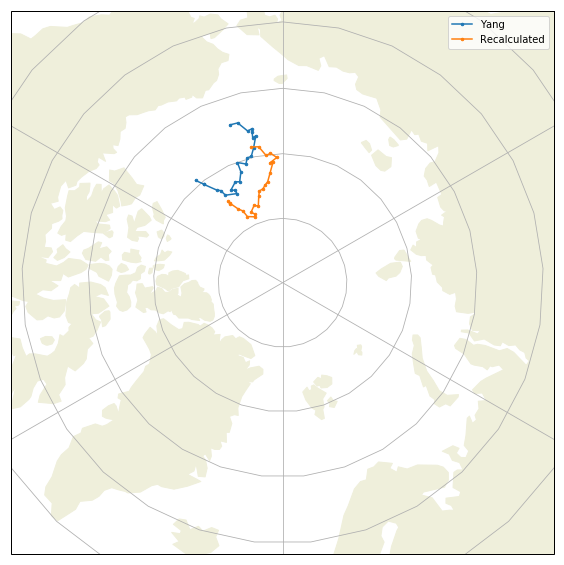

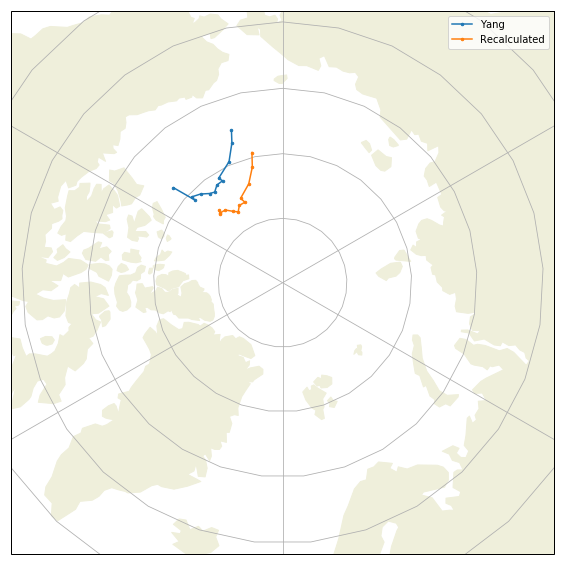

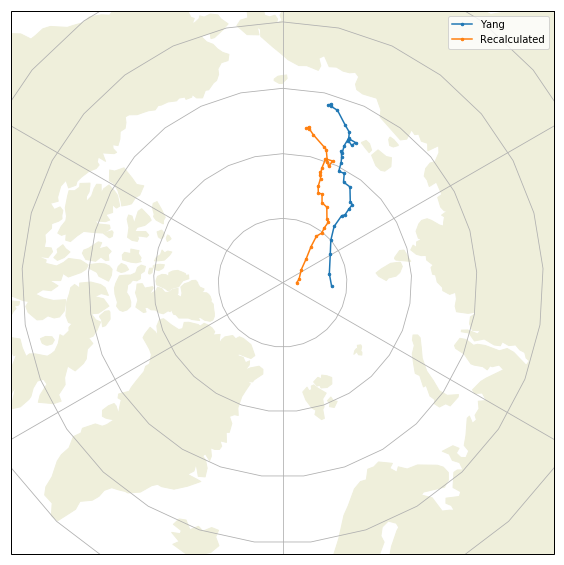

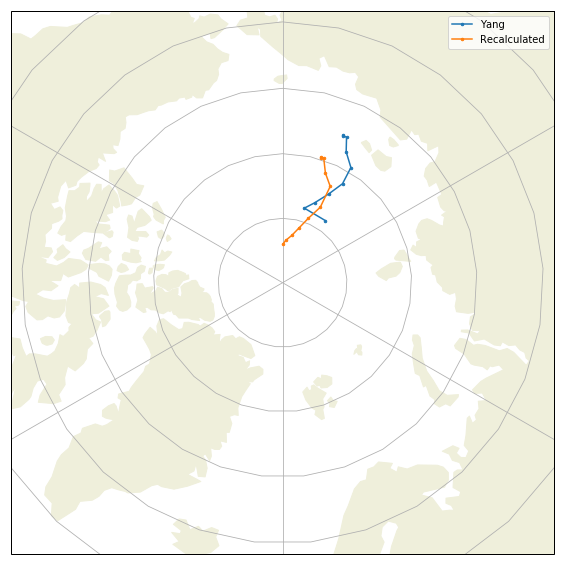

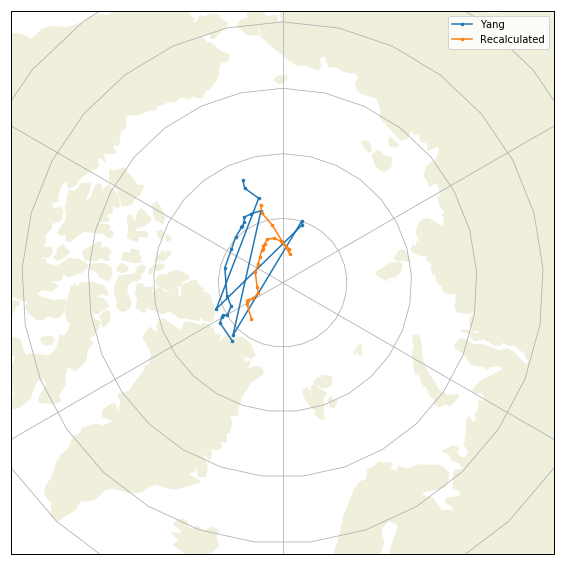

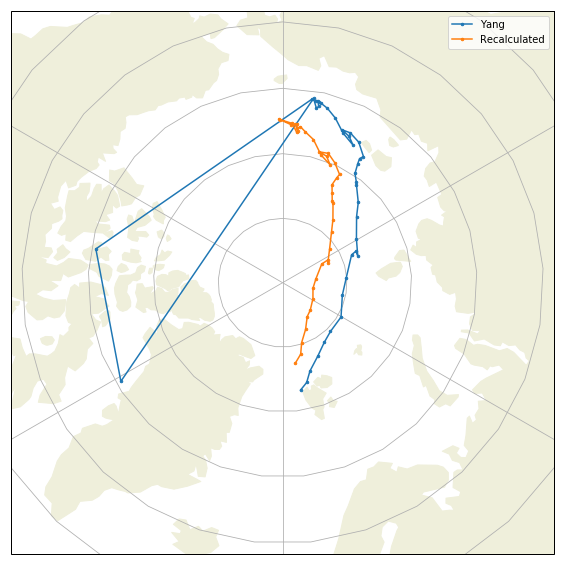

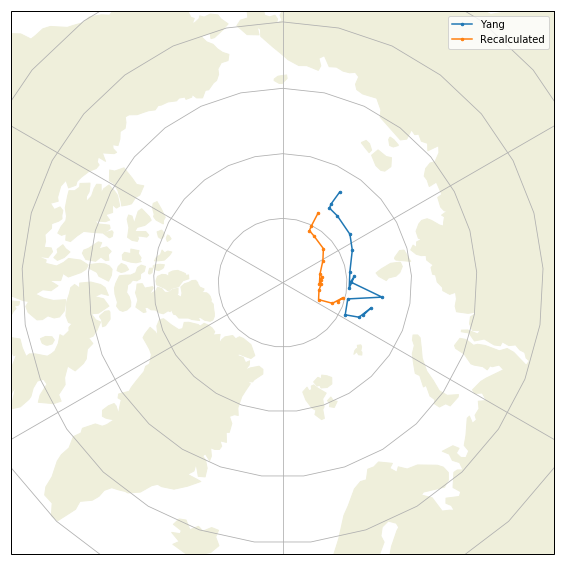

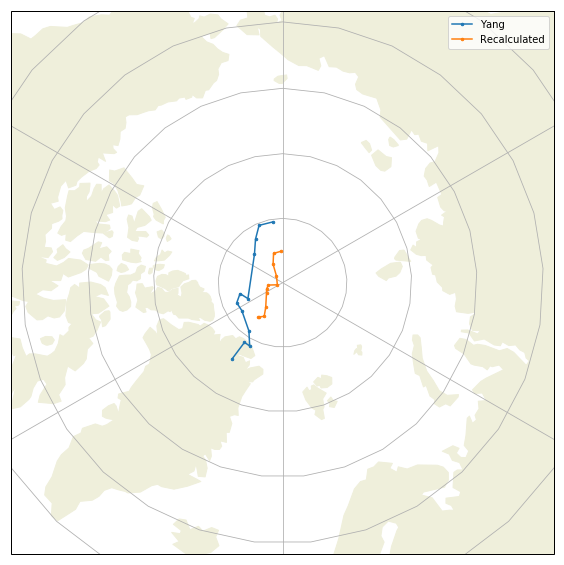

In [77]:
for np in ppt_df.NP.unique().astype(int):
    
    station = extract_station(ppt_df, np) # Extract Yang data for station NP

    if np == 27:
        statjn = station # NP27 position file is corrupted so do not update
    else:
        position = position_month(np) # Get position file and calculate monthly mean position
        statjn = station.join(position, rsuffix='_new') # Join DataFrame and Series

        # Get coords
        x0 = statjn['Lon'].values
        y0 = statjn['Lat'].values
        x1 = statjn['lon'].values
        y1 = statjn['lat'].values

        # Replace Lat and Lon
        statjn = statjn.drop(['Lat','Lon'], axis=1).rename({'lat': 'Lat', 'lon': 'Lon'}, axis=1) 
    
    # write to file
    statjn.to_csv(os.path.join(ediri, 'yang_np_precip_updated_coords_{:02d}.csv'.format(np))) # Write to file


    map_proj = ccrs.NorthPolarStereo()

    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(projection=map_proj)
    ax.set_extent([-180.,180.,65.,90.], ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.gridlines()

    traj0 = map_proj.transform_points(ccrs.PlateCarree(), x0, y0)
    traj1 = map_proj.transform_points(ccrs.PlateCarree(), x1, y1)

    ax.plot(traj0[:,0], traj0[:,1], '-o', ms=2.5, label='Yang')
    ax.plot(traj1[:,0], traj1[:,1], '-o', ms=2.5, label='Recalculated')

    ax.legend()
    
    #fig.savefig(os.path.join(ediri,'yang_np_precip_updated_coords_{:02d}.png'.format(np)))